I've recently come across a new-to-me, and generally relatively recently developed, method of non-parametric regression called trend filtering. There is a paper by Tibshirani (2014) that establishes nice theoretical results, namely that trend filtering achieves a better minimax convergence rate to the true underlying function than traditional smoothing splines. It is also very fast to fit in the mean squared error regime, as I will show below.

# Underlying Function

As usual for these demos, we start by defining our true underlying function and take some noisy sample of it. Here, I'm borrowing the example given in Politsch et al. (2020) which is a function that has a smooth global trend with some intermittent "bumps" given by some radial basis functions:

$$
f(t) = 6 \sum_{k=1}^3 (t - 0.5)^k + 2.5 \sum_{j=1}^4 (-1)^j \phi_j(t)
$$

where the $\phi_j$ are given by the Gaussian RBF:

$$
\phi_j(x) = \exp \left( - \left( \epsilon \left( x - \psi \right) \right)^2 \right)
$$

where $\psi$ is the center point and $\epsilon$ is the bandwidth. Here we set $\psi=0.2, 0.4, 0.6, 0.8$ and $\epsilon=50$. We take the inputs as $t_i \sim \text{Uniform}(0, 1)$

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import cvxpy as cp
import scipy

rng = np.random.default_rng()

In [81]:
t_i = rng.uniform(0, 1, 500)
t_i.sort()

In [82]:
def rbf(x, center, epsilon):
    return np.exp(-((epsilon * (x - center)) ** 2))

In [83]:
rbfs = [partial(rbf, center=i, epsilon=50) for i in [0.2, 0.4, 0.6, 0.8]]


true_y = 6 * np.sum([(t_i - 0.5) ** k for k in [1, 2, 3]], axis=0) + 2.5 * np.sum(
    [(-1) ** j * rbfs[j - 1](t_i) for j in [1, 2, 3, 4]], axis=0
)
obs_y = true_y + rng.normal(0, 0.5**2, len(t_i))

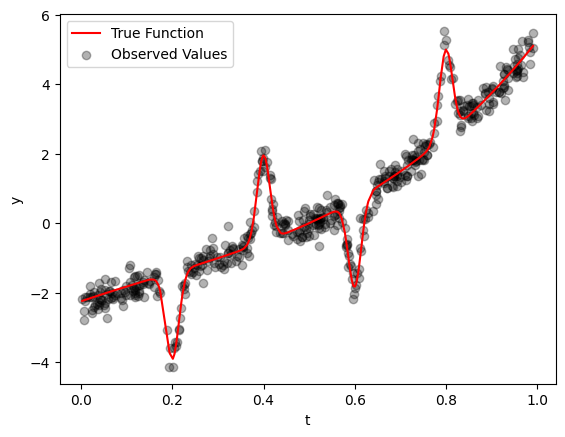

In [94]:
plt.plot(t_i, true_y, color="r")
plt.scatter(t_i, obs_y, alpha=0.3, color="black")
plt.xlabel("t")
plt.ylabel("y")
plt.legend(["True Function", "Observed Values"])

# Trend Filtering as a Basis Expansion

The first useful way to look at trend filtering is via a basis expansion perspective exactly like smoothing splines. Tibshirani prove that trend filtering has a basis function expansion given in equation (25), which I recreate here. Politsch et al. call this a *falling factorial* basis because of the iterated multiplicative form they take. Altering Tibshirani's notation slightly:

$$
j = 1, 2, \ldots, n \\
h_j(x) = x^{j-1} \quad \text{when} \quad j \leq k+1 \\
h_j(x) = \prod_{\ell=1}^k (x - x_{j-k-1+\ell}) * \mathbb{1}(x \ge x_{j-1}) \quad \text{when} \quad j \ge k+2
$$

where $n$ gives the total number of input points, and $k$ is the order of the trend filtering method. This number is related to the order of a smoothing spline in that it determines the degree of the piecewise polynomial that gets fitted to each segment of the input space. $k=0$ corresponds to a piecewise constant basis, $k=1$ to piecewise linear, and so on.

Python ranges generating sequences from 0 to $n-1$ so let's adjust our $j$ index to account for this:

$$
i = j - 1 = 0, 1, \ldots, n-1 \\
h_i(x) = x^i \quad \text{when} \quad i \le k \\
h_i(x) = \prod_{\ell=1}^k (x - x_{i-k+\ell}) * \mathbb{1}(x \ge x_{i}) = \prod_{\ell=0}^{k-1} (x - x_{i-k+\ell+1}) * \mathbb{1}(x \ge x_{i})\quad \text{when} \quad i \ge k+1
$$
However, Python lists are also zero-indexed so we need another adjustment on our subscripts to account for that too:
$$
h_i(x) = \prod_{\ell=0}^{k-1} (x - x_{i-k+\ell}) * \mathbb{1}(x \ge x_{i-1})\quad \text{when} \quad i \ge k+1
$$

In [98]:
def tf_basis(x, k, x_i):
    results = []
    n = len(x_i)
    for i in range(n):
        if i <= k:
            h = x**i
            results.append(h)
        elif i >= k + 1:
            h = 1
            for ell in range(k):
                h *= x - x_i[i - k + ell]
            h *= int(x >= x_i[i - 1])
            results.append(h)
    return results

Now, we can visualize this on some sample points. Here we set $k=2$, take our data to be $x_i=0, 0.2, 0.4, 0.6, 0.8, 1$, and plot the basis functions evaluated over the range $[0, 1]$:

Text(0.5, 1.0, 'k = 2')

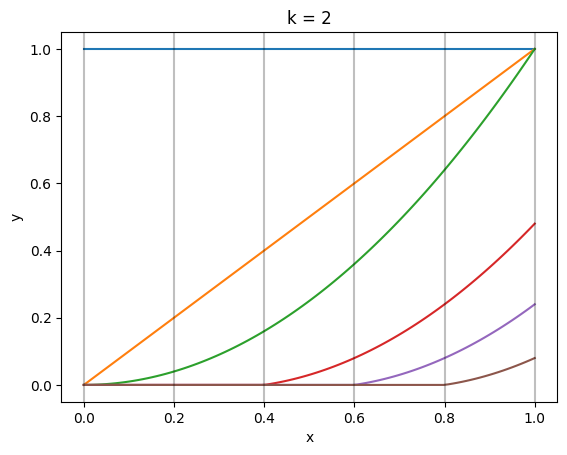

In [116]:
x_i = [0, 0.2, 0.4, 0.6, 0.8, 1]
xs = np.linspace(0, 1, 100)
test = np.array([tf_basis(x, 2, x_i) for x in xs])

for n in range(test.shape[1]):
    plt.plot(xs, test[:, n])

for x in x_i:
    plt.axvline(x, alpha=0.25, color="black")

plt.xlabel("x")
plt.ylabel("y")
plt.title("k = 2")

We can also see how changing $k$ changes the type of basis functions we get. Namely, if we set $k=0$ then we get a piecewise constant set of basis functions:

Text(0.5, 1.0, 'k = 0')

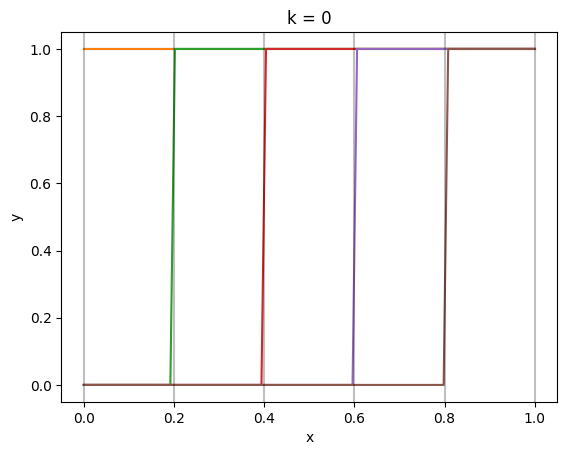

In [118]:
test = np.array([tf_basis(x, 0, x_i) for x in xs])

for n in range(test.shape[1]):
    plt.plot(xs, test[:, n])

for x in x_i:
    plt.axvline(x, alpha=0.25, color="black")

plt.xlabel("x")
plt.ylabel("y")
plt.title("k = 0")

# Fitting the Basis Function Approach

Now, we can express out model in the typical way as a function of the basis components:

$$
f(x) = \sum_{i=1}^n \alpha_i h_i(x)
$$

where $\alpha_i$ are our unknown coefficients. To fit this model we can form a design matrix where each row is the vector of the basis function outputs evaluated at the input point:

$$
\mathbf{X}_{i,j} = h_j(x_i) \quad \text{where} \quad i = 1, \ldots, n \quad j = 1, \ldots, n
$$

which gives us an $n \times n$ matrix. We can then form an $n \times 1$ coefficient vector and our regression becomes:

$$
y = \mathbf{X} \beta + \epsilon
$$

where if we assume that $\epsilon \sim \text{Normal}(0, \sigma^2)$ then we can use the standard least squares approach to find $\beta$. Note that because of the form of the basis expansion the first column of $\mathbf{X}$ will be all ones so we don't need to include a seperate intercept term.

We can also include an $\ell_1$ regularization term to our $\beta$ vector to promote sparsity, which gives us the objective function:

$$
\hat{\beta} = \argmin_\beta \frac{1}{2} \Vert{y - \mathbf{X}\beta} \Vert_2^2 + \lambda \Vert \beta \Vert_1
$$

Letting $k=1$ for a piecewise linear basis, and $\lambda = 0.01$, we can easily fit this model using cvxpy because our objective is convex:

In [179]:
k = 1
basis_eval = np.array([tf_basis(t, k, t_i) for t in t_i])
beta = cp.Variable(len(t_i))

objective = cp.Minimize(
    0.5 * cp.sum_squares(obs_y - basis_eval @ beta) + 0.01 * cp.norm(beta[k + 1 :], 1)
)
prob = cp.Problem(objective)
results = prob.solve(solver="CLARABEL", verbose=False)

Text(0.5, 1.0, 'k=1, lambda = 0.01')

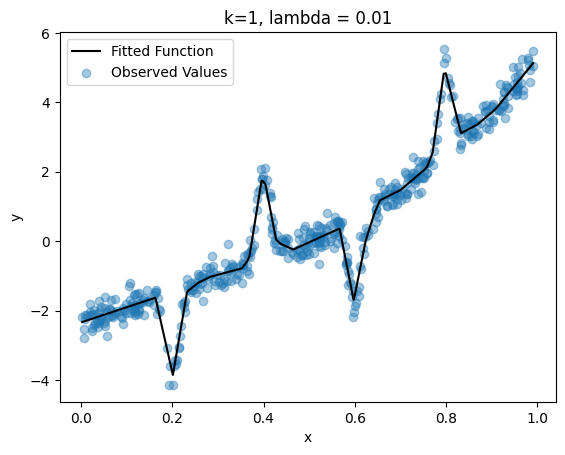

In [180]:
predict = basis_eval @ beta.value.round(2)
plt.plot(t_i, predict, color="black")
plt.scatter(t_i, obs_y, alpha=0.4)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Fitted Function", "Observed Values"])
plt.title("k=1, lambda = 0.01")

We can look at our fitted coefficients to see how many non-zero coefficients we get:

In [181]:
sum(np.abs(beta.value.round(2)) > 0)

39

We can also see what happens when we increase our regularization parameter to $\lambda=5$:

In [182]:
k = 1
basis_eval = np.array([tf_basis(t, k, t_i) for t in t_i])
beta = cp.Variable(len(t_i))

objective = cp.Minimize(
    0.5 * cp.sum_squares(obs_y - basis_eval @ beta) + 5 * cp.norm(beta[k + 1 :], 1)
)
prob = cp.Problem(objective)
results = prob.solve(solver="CLARABEL", verbose=False)

Text(0.5, 1.0, 'k=1, lambda = 5')

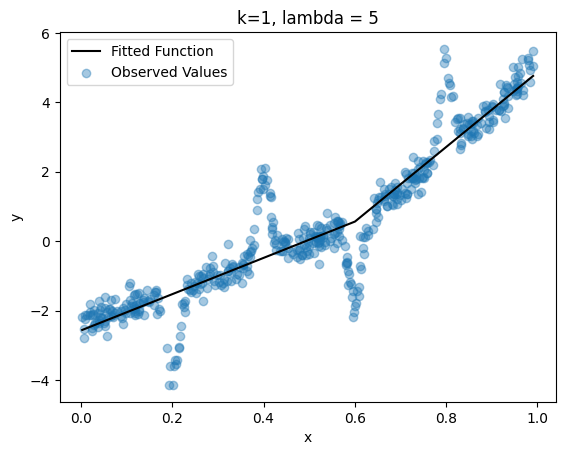

In [193]:
predict = basis_eval @ beta.value.round(2)
plt.plot(t_i, predict, color="black")
plt.scatter(t_i, obs_y, alpha=0.4)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Fitted Function", "Observed Values"])
plt.title("k=1, lambda = 5")

In [184]:
sum(np.abs(beta.value.round(2)) > 0)

3

We see a dramatically fewer number of non-zero coefficients, and we can also see one of the nice features of trend filtering: the "knots" of the basis functions are chosen automatically, in a sense. If we look at *where* the $\beta$ coefficients are non-zero:

In [190]:
np.where(np.abs(beta.value.round(2)) > 0)

(array([  0,   1, 305]),)

We can see that it's the first column, the intercept, and then at the first value of our input data and again at the 306th (adjusting for python indexes) value of our input data. Essentially, the model has chosen to fit a piecewise linear function from the first value to the 306th value, and another piecewise linear function over the rest of the domain. We can add the respective $x$-values of these points to our plot to see this:

Text(0.5, 1.0, 'k=1, lambda = 5')

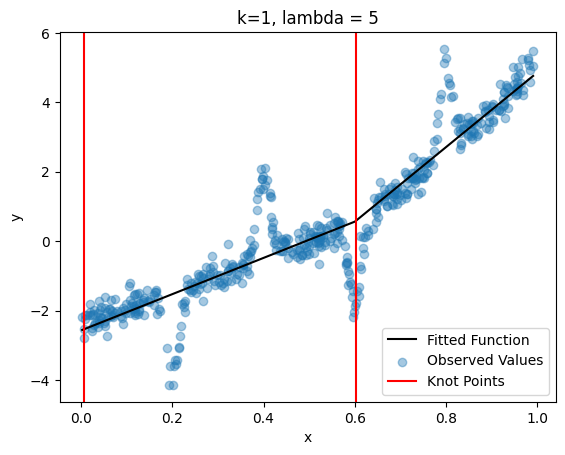

In [194]:
predict = basis_eval @ beta.value.round(2)
plt.plot(t_i, predict, color="black")
plt.scatter(t_i, obs_y, alpha=0.4)
plt.axvline(t_i[1], color="red")
plt.axvline(t_i[305], color="red")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Fitted Function", "Observed Values", "Knot Points"])
plt.title("k=1, lambda = 5")

Where you can see that values where the $\beta$ coefficients are non-zero are the same places where the slope of the lines changes. As the regularization parameter gets smaller, more and more knot points are selected, creating more and more piecewise functions over different segments of the input domain. This is a huge plus for trend filtering compared to smoothing splines: the model selects the knot points automatically.

# Difference Operator Approach

Now, the basis function approach is easy to interpret and understand, but it is very computationally expensive because we have to evaluate every basis function at every point. The size of our design matrix scales with the square of the number of inputs, which is untenable for even moderately sized datasets.

Luckily, there is an easier way: we can still fit a unique parameter to each input data point, but we can adjust our regularization penalty so that it constrains *adjacent* coefficients to be the same as each other. As Tibshirani proves, this process is equivalent to the basis function approach, and, as we shall see, grants certain sparsity properties that make the model fitting process much faster.

The first key to this is the *difference operator matrix*. This is what defines our regularization constraint. Let's first look at the case where $k=0$. Here, we want to constrain the first difference of our coefficients:

$$
\sum_{i=1}^{n-1} \vert \beta_i - \beta_{i+1} \vert
$$

and we can achieve this by creating this matrix given by equation (3) in Tibshirani:

$$
D^{(1)} = \begin{bmatrix} -1 & 1 & 0 & \ldots & 0 & 0 \\
0 & -1 & 1 & \ldots & 0 & 0 \\
\vdots \\
0 & 0 & 0 & \ldots & -1 & 1
\end{bmatrix} \in \mathbb{R}^{(n-1) \times n}
$$

and then we can see that:

$$
\Vert D^{(1)} \beta \Vert_1 = \sum_{i=1}^{n-1} \vert \beta_i - \beta_{i+1} \vert
$$

Defining our constraint like this gives us a huge computational speedup because the $D$ matrix is *banded*, meaning only specific values along the diagonal are non-zero and the rest are all exactly zero. This means that smart optimization algorithms can ignore the computations where it knows that there is a multiplication by zero, which don't contribute anything to the objective value.

The first order difference matrix gives us the piecewise-constant basis, but you can construct higher order differences to get other bases for higher values of $k$. For instance, the second difference matrix when $k=1$ looks like this:

$$
D^{(2)} = \begin{bmatrix} 1 & -2 & 1 & 0 & \ldots & 0 & 0 \\
0 & 1 & -2 & 1 & \ldots & 0 & 0 \\
\vdots \\
0 & 0 & 0 & \ldots & 1 & -2 & 1
\end{bmatrix} \in \mathbb{R}^{(n-2) \times n}
$$

and so on for higher orders. We can use some clever scipy and numpy operations to create sparse versions of these for us:

In [209]:
# TODO: Link to cvxpy page for reference to these functions
k = 1
n = len(t_i)

ones = np.ones(n)
if k == 0:
    D = scipy.sparse.spdiags(np.vstack([-ones, ones]), range(2), m=n - k - 1, n=n)
elif k == 1:
    D = scipy.sparse.spdiags(
        np.vstack([ones, -2 * ones, ones]), range(3), m=n - k - 1, n=n
    )
elif k == 2:
    D = scipy.sparse.spdiags(
        np.vstack([-ones, 3 * ones, -3 * ones, ones]), range(4), m=n - k - 1, n=n
    )

We can then define our objective function as:

$$
\hat{\beta} = \argmin_\beta \frac{1}{2} \Vert y - \beta \Vert_2^2 + \lambda \Vert D^{(k+1)} \beta \Vert_1
$$

In [239]:
beta = cp.Variable(n)

objective = cp.Minimize(
    0.5 * cp.sum_squares(obs_y - beta) + 100 * cp.norm(D @ beta, 1)
)
prob = cp.Problem(objective)

results = prob.solve(solver="CLARABEL")

Text(0.5, 1.0, 'k=1, lambda = 10')

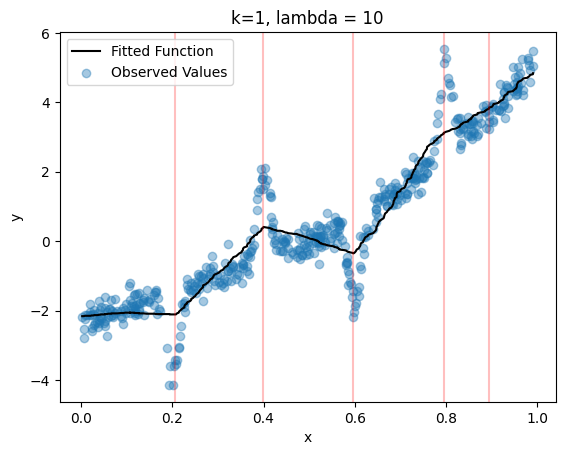

In [240]:
plt.plot(t_i, beta.value.round(2), color="black")
plt.scatter(t_i, obs_y, alpha=0.4)
for i in np.where(np.abs(D @ beta.value).round(2) > 0)[0]:
    plt.axvline(t_i[i], color="red", alpha=0.25)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Fitted Function", "Observed Values"])
plt.title("k=1, lambda = 10")

In [197]:
np.linalg.norm(D @ beta.value, ord=1)

1.9047123203714635

In [234]:
np.where(np.abs(D @ beta.value).round(2) > 0)

(array([ 83,  95, 111, 112, 119, 162, 169, 171, 185, 186, 202, 204, 217,
        281, 282, 302, 320, 325, 327, 328, 382, 389, 391, 403, 404, 418,
        419, 436]),)

In [235]:
t_i[83]

0.15928013786330253

# Cross-Validation

In [198]:
beta = cp.Variable(n)
lam = cp.Parameter(nonneg=True)

objective = cp.Minimize(0.5 * cp.sum_squares(obs_y - beta) + lam * cp.norm(D @ beta, 1))
prob = cp.Problem(objective)

results = []
for lam_value in np.logspace(-4, 6, 100):
    lam.value = lam_value
    prob.solve(solver="CLARABEL")
    results.append(np.sum((D @ beta.value).round(10)))

In [67]:
results

[7.614758493999998,
 7.614758495099996,
 7.614758493800002,
 7.614758494299999,
 7.614758494700001,
 7.6147584942,
 7.6147584939,
 7.6147584941,
 7.6147584946,
 7.614758493999998,
 7.614758493999998,
 7.614758494299998,
 7.6147584941,
 7.614758494300001,
 7.614758494699999,
 7.6147584954,
 7.6147584952999985,
 7.614758494800002,
 7.6147584945,
 7.614758494500001,
 7.6147584943,
 7.614758494699998,
 7.614758494,
 7.6147584946,
 7.614758494599999,
 7.6147584944,
 7.6147584947,
 7.614758494900002,
 7.614758493600001,
 7.6147584945,
 7.614758492999998,
 7.608071280800001,
 7.5714856654,
 7.515600412100001,
 7.4582764702999995,
 7.4226824059,
 7.3777678094,
 7.344590870699999,
 7.3107989468,
 7.269061142800002,
 7.2163940095,
 7.1562316686,
 7.114678934600001,
 7.062245333900001,
 7.014306190400001,
 6.9601171935,
 6.8917385524000006,
 6.8054544965,
 6.7514011752,
 6.690734318099999,
 6.614408964000001,
 6.5506443351999994,
 6.411484788700001,
 6.2291415321,
 6.0153051492000005,
 5.78042021

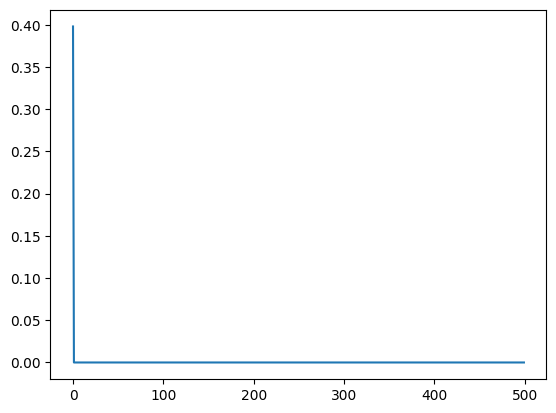

In [71]:
basis_beta = np.concatenate([beta.value[: k + 1], D @ beta.value])

plt.plot(basis_beta)

In [203]:
xs = np.linspace(-0.5, 1.5, 10000)
oos_test = np.array([tf_basis(x, k, t_i) for x in xs])

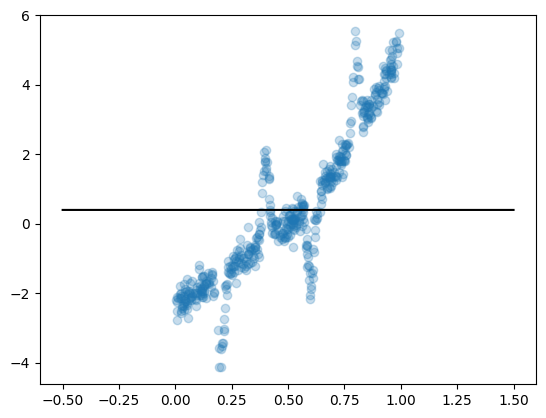

In [204]:
plt.scatter(t_i, obs_y, alpha=0.25)
plt.plot(xs, oos_test @ basis_beta, color="black")

# GLM

In [128]:
import jax.numpy as jnp
import jax
import optax

### Single Variate

In [314]:
x_i = rng.uniform(0, 100, 1000)
sort_idx = np.argsort(x_i)
true_y = np.sin(0.1 * x_i) ** 2 + 1

k = 50
theta = true_y / k
obs_y = rng.gamma(k, theta)

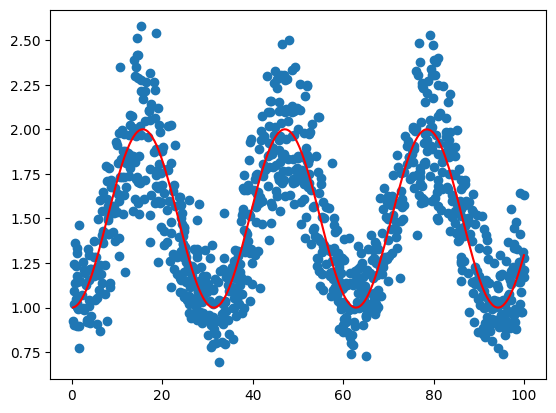

In [315]:
plt.scatter(x_i, obs_y)
plt.plot(x_i[sort_idx], true_y[sort_idx], color="r")

In [316]:
bins = 100
qs = np.linspace(1 / bins, (bins - 1) / bins, bins)
quantiles = np.quantile(x_i, qs, method="median_unbiased")
bin_nums = np.searchsorted(quantiles, x_i)

In [317]:
X = np.eye(bins + 1)[bin_nums]

In [318]:
@jax.jit
def gamma_deviance(y_hat, y):
    return 2 * (jnp.log(y_hat / y) + y / y_hat - 1)


@jax.jit
def trend_filter_penalty(beta, D):
    return jnp.linalg.norm(D @ beta, ord=1)


def gamma_trend_filter(beta, X, y, lam, D):
    mu = jnp.exp(X @ beta)
    return gamma_deviance(mu, y).sum() + lam * trend_filter_penalty(beta, D)

In [345]:
ones = np.ones(bins + 1)
D = scipy.sparse.spdiags(
    np.vstack([-ones, ones]), range(2), m=bins, n=bins + 1
).toarray()
D = jnp.asarray(D)
beta = jnp.asarray(rng.random(bins + 1))

In [346]:
X_jax = jnp.asarray(X)
y_jax = jnp.asarray(obs_y)
lam = 5


def obj(beta):
    return gamma_trend_filter(beta, X_jax, y_jax, lam, D)


solver = optax.lbfgs(
    linesearch=optax.scale_by_zoom_linesearch(
        max_linesearch_steps=15, approx_dec_rtol=None, tol=1e-3, increase_factor=4
    )
)
opt_state = solver.init(beta)
value_and_grad = optax.value_and_grad_from_state(obj)

old_value = obj(beta)
no_prog_steps = 0
while True:
    value, grad = value_and_grad(beta, state=opt_state)
    print(f"Objective Value: {value}")
    print(f"Gradient Norm: {jnp.linalg.norm(grad, ord=1)}")

    if jnp.abs(grad).sum() < 1e-5:
        print("Gradient Norm Stop")
        break

    updates, opt_state = solver.update(
        grad,
        opt_state,
        beta,
        value=value,
        grad=grad,
        value_fn=obj,
    )
    beta = optax.apply_updates(beta, updates)

    new_value = obj(beta)
    if jnp.abs((new_value - old_value) / old_value) < 1e-3:
        no_prog_steps += 1
    if no_prog_steps > 5:
        print("No objective progress stop")
        break
    old_value = new_value

Objective Value: 317.8957824707031
Gradient Norm: 1131.076904296875
Objective Value: 203.23158264160156
Gradient Norm: 1096.0804443359375
Objective Value: 128.52243041992188
Gradient Norm: 946.3477783203125
Objective Value: 74.89199829101562
Gradient Norm: 677.6984252929688
Objective Value: 66.75651550292969
Gradient Norm: 632.0709838867188
Objective Value: 57.4463996887207
Gradient Norm: 600.0643310546875
Objective Value: 51.35066223144531
Gradient Norm: 435.5057373046875
Objective Value: 48.967533111572266
Gradient Norm: 456.1019287109375
Objective Value: 47.578529357910156
Gradient Norm: 369.0650634765625
Objective Value: 46.71861267089844
Gradient Norm: 325.869873046875
Objective Value: 45.813358306884766
Gradient Norm: 270.1483154296875
Objective Value: 45.444725036621094
Gradient Norm: 261.2182312011719
Objective Value: 44.777732849121094
Gradient Norm: 356.0535583496094
Objective Value: 44.35054016113281
Gradient Norm: 371.4313659667969
Objective Value: 43.716068267822266
Gradie

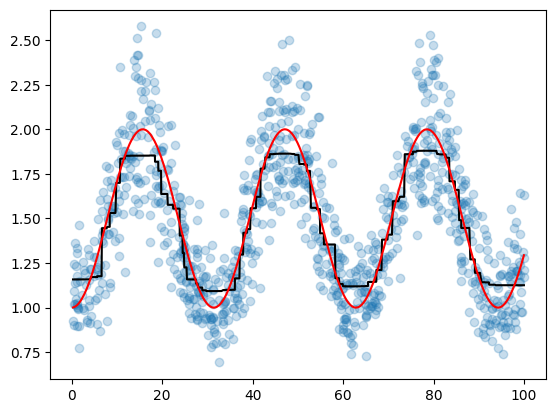

In [347]:
plt.plot(x_i[sort_idx], np.asarray(jnp.exp(X_jax @ beta))[sort_idx], color="black")
plt.plot(x_i[sort_idx], true_y[sort_idx], color="r")
plt.scatter(x_i, obs_y, alpha=0.25)

### Multi-Variate

In [634]:
x_i_1 = rng.uniform(0, 100, 10000)
x_i_2 = rng.uniform(0, 1, 10000)
sort_idx_1 = np.argsort(x_i_1)
sort_idx_2 = np.argsort(x_i_2)
true_y = np.sin(0.1 * x_i_1) + np.exp(x_i_2)

k = 500
theta = true_y / k
obs_y = rng.gamma(k, theta)

In [656]:
import scipy.interpolate

plot_x = np.linspace(x_i_1.min(), x_i_1.max(), 100)
plot_y = np.linspace(x_i_2.min(), x_i_2.max(), 100)

x_grid, y_grid = np.meshgrid(plot_x, plot_y)

Z = scipy.interpolate.griddata((x_i_1, x_i_2), true_y, (x_grid, y_grid), method="cubic")

In [659]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(x=plot_x, y=plot_y, z=Z)])
fig.show()

In [686]:
import interpret
import interpret.glassbox

# Changing interactions to zero substantially changes this
model = interpret.glassbox.ExplainableBoostingRegressor(
    ["x_1", "x_2"],
    ["continuous", "continuous"],
    objective="gamma_deviance",
    smoothing_rounds=600,
)
model.fit(np.vstack([x_i_1, x_i_2]).T, obs_y)

ExplainableBoostingRegressor(feature_names=['x_1', 'x_2'],
                             feature_types=['continuous', 'continuous'],
                             objective='gamma_deviance', smoothing_rounds=600)

In [687]:
predicted = model.predict(np.vstack([x_i_1, x_i_2]).T)

Z = scipy.interpolate.griddata(
    (x_i_1, x_i_2), predicted, (x_grid, y_grid), method="cubic"
)

In [688]:
fig = go.Figure(data=[go.Surface(x=plot_x, y=plot_y, z=Z)])
fig.show()

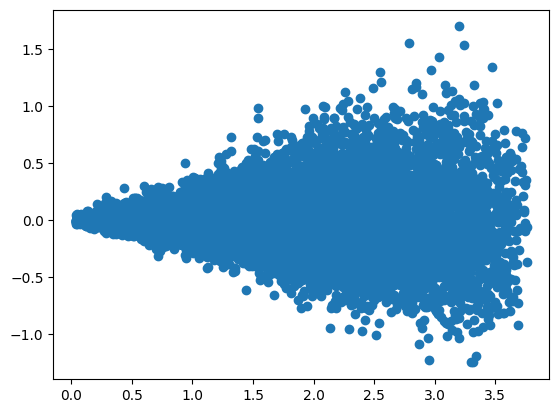

In [633]:
predicted = model.predict(np.vstack([x_i_1, x_i_2]).T)

plt.scatter(predicted, obs_y - predicted)

In [593]:
bins = 100
qs = np.linspace(1 / bins, (bins - 1) / bins, bins)

quantiles_1 = np.quantile(x_i_1, qs, method="median_unbiased")
bin_nums_1 = np.searchsorted(quantiles_1, x_i_1)

quantiles_2 = np.quantile(x_i_2, qs, method="median_unbiased")
bin_nums_2 = np.searchsorted(quantiles_2, x_i_2)

In [594]:
def get_one_hot(bins, idx):
    return np.eye(bins + 1)[idx]


X = np.hstack([get_one_hot(bins, bin_nums_1), get_one_hot(bins, bin_nums_2)])

In [608]:
def get_D_matrix(bins):
    ones = np.ones(bins + 1)
    D = scipy.sparse.spdiags(
        np.vstack([-ones, ones]), range(2), m=bins, n=bins + 1
    ).toarray()
    return D


D = get_D_matrix(bins)
D = np.block(
    [[D, np.zeros((D.shape[0], D.shape[1]))], [np.zeros((D.shape[0], D.shape[1])), D]]
)
D = jnp.asarray(D)
beta = jnp.asarray(rng.random(2 * (bins + 1) + 1))

In [609]:
@jax.jit
def gamma_deviance(y_hat, y):
    return 2 * (jnp.log(y_hat / y) + y / y_hat - 1)


@jax.jit
def trend_filter_penalty(beta, D):
    return jnp.linalg.norm(D @ beta, ord=1)


def gamma_trend_filter(beta, X, y, lam, D):
    intercept = beta[0]
    beta = beta[1:]
    mu = jnp.exp(intercept + X @ beta)
    return gamma_deviance(mu, y).sum() + lam * trend_filter_penalty(beta, D)

In [610]:
X_jax = jnp.asarray(X)
y_jax = jnp.asarray(obs_y)
lam = 0


def obj(beta):
    return gamma_trend_filter(beta, X_jax, y_jax, lam, D)


solver = optax.lbfgs(
    linesearch=optax.scale_by_zoom_linesearch(
        max_linesearch_steps=15, approx_dec_rtol=None, tol=1e-3, increase_factor=4
    )
)
opt_state = solver.init(beta)
value_and_grad = optax.value_and_grad_from_state(obj)

old_value = obj(beta)
no_prog_steps = 0
while True:
    value, grad = value_and_grad(beta, state=opt_state)
    print(f"Objective Value: {value}")

    if jnp.abs(grad).sum() < 1e-5:
        print("Gradient Norm Stop")
        break

    updates, opt_state = solver.update(
        grad,
        opt_state,
        beta,
        value=value,
        grad=grad,
        value_fn=obj,
    )
    beta = optax.apply_updates(beta, updates)

    new_value = obj(beta)
    if jnp.abs((new_value - old_value) / old_value) < 1e-3:
        no_prog_steps += 1
    if no_prog_steps > 5:
        print("No objective progress stop")
        break
    old_value = new_value

Objective Value: 11208.080078125
Objective Value: 4922.900390625
Objective Value: 4790.2646484375
Objective Value: 4549.25634765625
Objective Value: 4403.8466796875
Objective Value: 4289.47998046875
Objective Value: 4173.916015625
Objective Value: 4030.322021484375
Objective Value: 3829.55224609375
Objective Value: 3537.106201171875
Objective Value: 3117.025390625
Objective Value: 2551.197021484375
Objective Value: 1872.9775390625
Objective Value: 1101.699951171875
Objective Value: 831.5046997070312
Objective Value: 756.0828857421875
Objective Value: 728.01025390625
Objective Value: 713.8626098632812
Objective Value: 703.7139892578125
Objective Value: 693.3444213867188
Objective Value: 680.9779663085938
Objective Value: 667.7976684570312
Objective Value: 655.005859375
Objective Value: 649.4990844726562
Objective Value: 645.4562377929688
Objective Value: 643.32470703125
Objective Value: 642.3488159179688
Objective Value: 641.9208984375
Objective Value: 641.7252807617188
Objective Value:

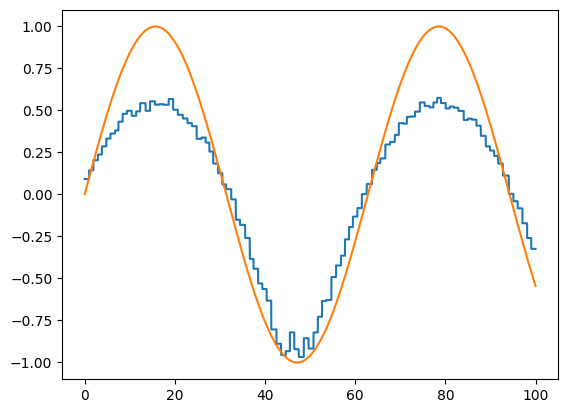

In [615]:
plt.plot(x_i_1[sort_idx_1], np.asarray(beta[0] + X[:, :101] @ beta[1:102])[sort_idx_1])
plt.plot(x_i_1[sort_idx_1], np.sin(0.1 * x_i_1)[sort_idx_1])

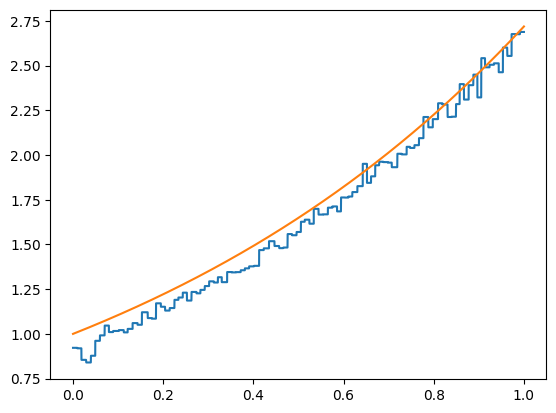

In [616]:
plt.plot(
    x_i_2[sort_idx_2],
    np.asarray(jnp.exp(X[:, 101:] @ beta[102:]))[sort_idx_2],
)
plt.plot(x_i_2[sort_idx_2], np.exp(x_i_2)[sort_idx_2])

In [600]:
pred_y = np.asarray(jnp.exp(X @ beta))
plt.scatter(obs_y, pred_y - true_y)

TypeError: dot_general requires contracting dimensions to have the same shape, got (202,) and (203,).